# Seleccción y construcción del modelo

En este libro, se muestra el procedimiento para realizar el preprocesamiento de los datos, la selección de los parámetros, el clasificador a utilizar y su evaluación. A continuación, se presentan las librerías necesarias para correr los bloques de código, es importante que se trabaje sobre Python 2.7 por temas de soporte y compatibilidad con algunas de las librerías.

In [1]:
import pandas as pd
import unidecode, re, string, dill

from wordcloud import WordCloud
from nltk import word_tokenize 
from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline


## 1. Lectura de los datos de entrenamiento

Los datos de entrenamiento se cargan desde un archivo CSV, donde la primera columna es una etiqueta que indica si el mensaje dado esta relacionado con temáticas del SIATA o no y la segunda columna es el mensaje en sí.

Usando estos ejemplos de siata / nosiata, se entrena un modelo de aprendizaje automático para discriminar los mensajes relacionados con las tematicas del SIATA y los que no. Luego, con este modelo se podran clasificar mensajes arbitrarios no etiquetados.

In [2]:
data = pd.read_csv('datos/entrenamiento.csv')
data = data.sample(frac=1)

### Análisis exploratorio de los datos de entrenamiento

El set de entrenamiento consta de 1000 mensajes, de los cuales 500 fueron etiquetados como siata ya que se encuentran asociados a temáticas del proyecto, los otros 500 corresponden a temáticas generales que no se relacionan con el SIATA.

In [3]:
data.groupby('label').describe()

text
label                                                            
nosiata count                                                 500
        unique                                                500
        top     #NoticiasTM ((Al aire)) Desde hoy se dio inici...
        freq                                                    1
siata   count                                                 500
        unique                                                500
        top     4. En medición de ##CalidadDelAire Material Pa...
        freq                                                    1

Se verifica que los tweets seleccionados para el conjunto de entrenamiento sean validos, es decir, que tengan una longitud superior a cero.

In [4]:
data['length'] = data['text'].map(lambda text: len(text))
print data.head(10)

       label                                               text  length
927    siata  @siatamedellin @ParqueExplora @Areametropol  q...     115
990  nosiata  Esta hablando de el mismo viola personas secue...     136
467  nosiata      @egolaxista_ Controle su facsismo idiomático.      46
996  nosiata  Pa que vean pues como es que va la vaina prepa...     119
542    siata  Esta lluvia a esta hora sólo provoca que me es...     123
313  nosiata  Buenas yo lo sentí en el sexto piso en el barr...     146
620    siata                Por fín me doy cuenta de un Temblor      36
214  nosiata  Flores de guayacán (cañaguate para nuestros co...      95
65     siata  El agua es lo que le da valor a la tierra.  En...     141
445  nosiata  QUE SERÁ LO QUE QUIERE @CMILANOTICIA Y SU prog...     133


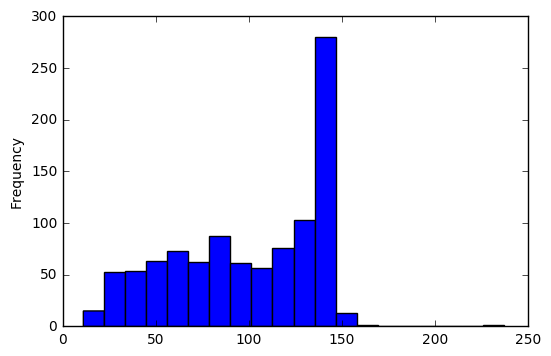

In [6]:
data.length.plot(bins=20, kind='hist')

In [7]:
data.length.describe()

count    1000.000000
mean       99.825000
std        39.612391
min        11.000000
25%        67.000000
50%       108.000000
75%       138.000000
max       237.000000
Name: length, dtype: float64

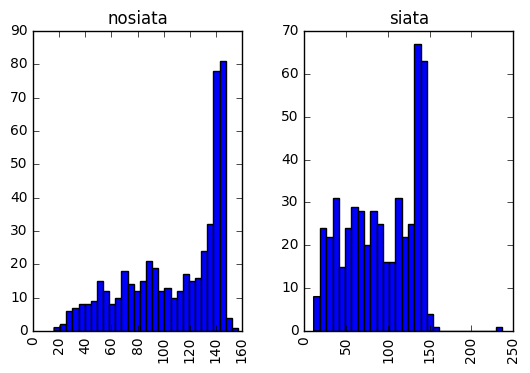

In [9]:
histData = data.hist(column='length', by='label', bins=30)

En el eje X puede verse la longitud del mensaje y en el Y la frecuencia con la que se presenta esa longitud

## 2. Preprocesamiento de los datos

Los datos a utilizar en el análisis son de tipo texto, por lo que se deben depurar las cadenas de caracteres que no aportan información al estudio. Se tomó como base la preparación y limpieza de texto detallada en el artículo "A Sentiment Analysis System of Spanish Tweets and Its Application in Colombia 2014 Presidential Election". A continuación, se listan los pasos seguidos para realizar la limpieza:

1. Eliminación de direcciones URL.
2. Eliminación de emojis, reconociéndolos con expresiones regulares.
3. Eliminación de signos de puntuación.
4. Eliminación de acentos (tildes, virgulillas, diéresis, etc.).
5. Eliminación de números.
6. Los caracteres desconocidos se asignan a su variante ASCII más cercana, utilizando el módulo Python Unidecode.
7. Se cambian las letras mayúsculas por minúsculas.
8. Se aplica una función de tokenización que se encarga de descomponer los comentarios en sus unidades mínimas.
9. Se aplica una función de steamming usando el modulo NLTK para reducir las palabras a su raiz.


In [8]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticones
                           u"\U0001F300-\U0001F5FF"  # símbolos y pictografías
                           u"\U0001F680-\U0001F6FF"  # símbolos de transporte y mapa
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
                           
emoji_pattern2 = re.compile(u"[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]", flags=re.UNICODE)                           
emoji_pattern3 = re.compile(u"\u2026", flags=re.UNICODE) # caracter tres puntos                 

stemmer = SnowballStemmer("spanish")

In [9]:
def prepararTweetStemmer(mensaje):
    mensaje = re.sub(r"http\S+", "", mensaje)
    mensaje = re.sub(r"[0-9]\S+", "", mensaje)
    mensaje = re.sub(emoji_pattern, "", mensaje)
    mensaje = re.sub(emoji_pattern2, "", mensaje)
    mensaje = re.sub(emoji_pattern3, "", mensaje)
    mensaje = re.sub('[%s]' % re.escape(string.punctuation), "", mensaje)
    mensaje = re.sub(r"¡|¿+", "", mensaje)
    mensaje = unicode(mensaje, 'utf8').lower()
    word_tokens = word_tokenize(mensaje)
    
    filtered_sentence = []
    filtered_sentence = [unidecode.unidecode(stemmer.stem(w)) for w in word_tokens]
    
    return filtered_sentence

In [10]:
def prepararTweet(mensaje):
    mensaje = re.sub(r"http\S+", "", mensaje)
    mensaje = re.sub(r"[0-9]\S+", "", mensaje)
    mensaje = re.sub(emoji_pattern, "", mensaje)
    mensaje = re.sub(emoji_pattern2, "", mensaje)
    mensaje = re.sub(emoji_pattern3, "", mensaje)
    mensaje = re.sub('[%s]' % re.escape(string.punctuation), "", mensaje)
    mensaje = re.sub(r"¡|¿+", "", mensaje)
    mensaje = unicode(mensaje, 'utf8').lower()
    word_tokens = word_tokenize(mensaje)
    filtered_sentence = word_tokens
    
    return filtered_sentence

### Conversión de los datos a vectores

Ahora se convierte cada mensaje representado como una lista de tokens, en un vector que los modelos de aprendizaje automático pueden entender. 

Para ello, se cuenta cuántas veces ocurre una palabra en cada mensaje (frecuencia de término), se ponderanan los conteos para que los tokens frecuentes obtengan un menor peso (frecuencia inversa del documento) y se normalizan los vectores a la longitud de la unidad, para abstraer de la longitud del texto original (norma L2).

Cada vector tiene tantas dimensiones como palabras únicas en el mensaje.

In [11]:
vectorConteo = CountVectorizer(analyzer = prepararTweetStemmer).fit(data['text'])
matrizTerminos = vectorConteo.transform(data['text'])

Después del conteo, la ponderación y normalización se puede hacer con TF-IDF, usando scikit-learn

In [12]:
tfidfTransformer = TfidfTransformer().fit(matrizTerminos)
mensajesTfidf = tfidfTransformer.transform(matrizTerminos)

Se seleccionan aleatoriamente los datos que hacen parte del conjunto de entrenamiento y de evaluación

In [13]:
mensajeEntrenamiento, mensajePrueba, labelEntrenamiento, labelPrueba = \
    train_test_split(data['text'], data['label'], test_size=0.5)

## 3. Construcción del modelo

Se busca la mejor combinación de parámetros para construir los clasificadores, basándose en el porcentaje de exactitud; luego, se realiza el proceso de evaluación usando el mejor de los modelos. Con este proceso se puede ver el efecto de la ponderación IDF (Inverse Document Frequency) sobre la precisión, el coste de procesamiento del stemmer y si realmente ayuda.

### Clasificador -  Naive Bayes

In [14]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=prepararTweetStemmer)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (prepararTweetStemmer, prepararTweet),
}

grid = GridSearchCV(
        pipeline,  # pipeline from above
        params,  # parameters to tune via cross validation
        refit = True,  # fit using all available data at the end, on the best found param combination
        n_jobs = -1,  # number of cores to use for parallelization; -1 for "all cores"
        scoring = 'accuracy',  # what score are we optimizing?
    )

Se realiza el entrenamiento con la variación de parámetros dada anteriormente.

In [15]:
clasificadorBayes = grid.fit(mensajeEntrenamiento, labelEntrenamiento)

Se imprime cual es la mejor combinación de parámetros para el clasificador, esto usando como métrica el accuracy score.

In [16]:
clasificadorBayes.best_estimator_ 

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function prepararTweetStemmer at 0x7f21c3babde8>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepr...         use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Se muestra la tabla con los porcentajes de exactitud obtenidos durante el entrenamiento, la evaluación y el tiempo de demora del clasificador según la combinación de parámetros dada.

In [17]:
pd.DataFrame.from_dict(clasificadorBayes.cv_results_, orient='columns', dtype=None)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bow__analyzer,param_tfidf__use_idf,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.756470,0.422039,0.822,0.990005,<function prepararTweetStemmer at 0x7f21c3babde8>,True,"{u'tfidf__use_idf': True, u'bow__analyzer': <f...",1,0.844311,0.993994,0.820359,0.990991,0.801205,0.985030,0.051088,0.025816,0.017628,0.003725
1,0.795807,0.363770,0.816,0.962990,<function prepararTweetStemmer at 0x7f21c76581b8>,False,"{u'tfidf__use_idf': False, u'bow__analyzer': <...",2,0.814371,0.957958,0.808383,0.957958,0.825301,0.973054,0.089446,0.033040,0.006999,0.007116
2,0.245680,0.106092,0.814,0.993997,<function prepararTweet at 0x7f21c3bab500>,True,"{u'tfidf__use_idf': True, u'bow__analyzer': <f...",3,0.808383,0.990991,0.820359,0.993994,0.813253,0.997006,0.023942,0.012175,0.004922,0.002456
3,0.298190,0.103248,0.798,0.976992,<function prepararTweet at 0x7f21c3864230>,False,"{u'tfidf__use_idf': False, u'bow__analyzer': <...",4,0.802395,0.978979,0.808383,0.966967,0.783133,0.985030,0.057645,0.004413,0.010763,0.007507


Se realiza la clasificación de los datos de prueba para realizar la evaluación del modelo.

In [18]:
labelPrediccion = clasificadorBayes.predict(mensajePrueba)

Se genera la matriz de confusión con el numero de datos clasificados correcta y erróneamente, el valor de exactitud del clasificador y un reporte detallado.

In [19]:
tn, fp, fn, tp = confusion_matrix(y_true = labelPrueba,y_pred = labelPrediccion).ravel()
(tn, fp, fn, tp)

(205, 38, 40, 217)

In [20]:
print('Accuracy score: {}'.format(accuracy_score(labelPrueba, labelPrediccion)))

Accuracy score: 0.844


In [21]:
print classification_report(labelPrueba, labelPrediccion)

             precision    recall  f1-score   support

    nosiata       0.84      0.84      0.84       243
      siata       0.85      0.84      0.85       257

avg / total       0.84      0.84      0.84       500



Se serializa y almacena en el disco el clasificador con la mejor combinación de parámetros entrenado y listo para utilizarse.

In [23]:
with open('modelos/clasificadorBayes.pkl', 'wb') as archivoClasificadorBayes:
    dill.dump(clasificadorBayes, archivoClasificadorBayes)

#clasificadorBayes_carga = dill.load(open('clasificadorBayes.pkl'))

### Clasificador - Máquinas de vectores de soporte (SVM)

In [24]:
pipelineSVM = Pipeline([
                        ('bow', CountVectorizer(analyzer=prepararTweetStemmer)),  # strings to token integer counts
                        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                        ('classifier', SVC()),  # train on TF-IDF vectors w/ Naive Bayes classifier
                    ])

paramSVM = [
              {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear']},
              {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['poly']},
              {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['rbf']},
              {'tfidf__use_idf': (True, False) },
              { 'bow__analyzer': (prepararTweetStemmer, prepararTweet)},
            ]

gridSVM = GridSearchCV(
        pipelineSVM,  # pipeline from above
        paramSVM,  # parameters to tune via cross validation
        refit = True,  # fit using all available data at the end, on the best found param combination
        n_jobs = -1,  # number of cores to use for parallelization; -1 for "all cores"
        scoring = 'accuracy',  # what score are we optimizing?
    )

Se realiza el entrenamiento con la variación de parámetros dada anteriormente.

In [25]:
clasificadorSVM = gridSVM.fit(mensajeEntrenamiento, labelEntrenamiento) # find the best combination from param_svm

Se imprime cual es la mejor combinación de parámetros para el clasificador, esto usando como métrica el accuracy score.

In [26]:
clasificadorSVM.best_estimator_ 

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function prepararTweetStemmer at 0x7f21c7612320>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepr...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Se muestra la tabla con los porcentajes de exactitud obtenidos durante el entrenamiento, la evaluación y el tiempo de demora del clasificador según la combinación de parámetros dada.

In [27]:
pd.DataFrame.from_dict(clasificadorSVM.cv_results_, orient='columns', dtype=None)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bow__analyzer,param_classifier__C,param_classifier__kernel,param_tfidf__use_idf,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.728083,0.327703,0.516,0.519001,NaN,0.1,linear,NaN,"{u'classifier__kernel': u'linear', u'classifie...",3,0.514970,0.513514,0.514970,0.525526,0.518072,0.517964,0.019086,0.009905,0.001461,0.004958
1,0.681895,0.329627,0.800,0.989999,NaN,1,linear,NaN,"{u'classifier__kernel': u'linear', u'classifie...",1,0.820359,0.990991,0.802395,0.987988,0.777108,0.991018,0.034422,0.010325,0.017730,0.001422
2,0.660925,0.323289,0.798,1.000000,NaN,10,linear,NaN,"{u'classifier__kernel': u'linear', u'classifie...",2,0.832335,1.000000,0.796407,1.000000,0.765060,1.000000,0.007043,0.007094,0.027474,0.000000
3,0.667285,0.333104,0.514,0.513999,NaN,0.1,poly,NaN,"{u'classifier__kernel': u'poly', u'classifier_...",4,0.514970,0.513514,0.514970,0.513514,0.512048,0.514970,0.017806,0.005545,0.001376,0.000687
4,0.741759,0.345818,0.514,0.513999,NaN,1,poly,NaN,"{u'classifier__kernel': u'poly', u'classifier_...",4,0.514970,0.513514,0.514970,0.513514,0.512048,0.514970,0.048656,0.009443,0.001376,0.000687
5,0.792158,0.330912,0.514,0.513999,NaN,10,poly,NaN,"{u'classifier__kernel': u'poly', u'classifier_...",4,0.514970,0.513514,0.514970,0.513514,0.512048,0.514970,0.077257,0.007911,0.001376,0.000687
6,0.773525,0.348680,0.514,0.513999,NaN,0.1,rbf,NaN,"{u'classifier__kernel': u'rbf', u'classifier__...",4,0.514970,0.513514,0.514970,0.513514,0.512048,0.514970,0.067082,0.020161,0.001376,0.000687
7,0.790429,0.347855,0.514,0.513999,NaN,1,rbf,NaN,"{u'classifier__kernel': u'rbf', u'classifier__...",4,0.514970,0.513514,0.514970,0.513514,0.512048,0.514970,0.062448,0.007654,0.001376,0.000687
8,0.714685,0.335574,0.514,0.513999,NaN,10,rbf,NaN,"{u'classifier__kernel': u'rbf', u'classifier__...",4,0.514970,0.513514,0.514970,0.513514,0.512048,0.514970,0.016558,0.006509,0.001376,0.000687
9,0.727478,0.339457,0.514,0.513999,NaN,NaN,NaN,True,{u'tfidf__use_idf': True},4,0.514970,0.513514,0.514970,0.513514,0.512048,0.514970,0.006144,0.008308,0.001376,0.000687


In [28]:
pd.DataFrame.from_dict(clasificadorSVM.cv_results_, orient='columns', dtype=None).to_csv('svm')

Se realiza la clasificación de los datos de prueba para realizar la evaluación del modelo.

In [29]:
labelPrediccionSVM = clasificadorSVM.predict(mensajePrueba)

Se genera la matriz de confusión con el numero de datos clasificados correcta y erróneamente, el valor de exactitud del clasificador y un reporte detallado.

In [30]:
tn, fp, fn, tp = confusion_matrix(y_true = labelPrueba, y_pred = labelPrediccionSVM).ravel()
(tn, fp, fn, tp)

(211, 32, 44, 213)

In [32]:
print('Accuracy score: {}'.format(accuracy_score(labelPrueba, labelPrediccionSVM)))

Accuracy score: 0.848


In [33]:
print classification_report(labelPrueba, labelPrediccionSVM)

             precision    recall  f1-score   support

    nosiata       0.83      0.87      0.85       243
      siata       0.87      0.83      0.85       257

avg / total       0.85      0.85      0.85       500



Se serializa y almacena en el disco el clasificador con la mejor combinación de parámetros entrenado y listo para utilizarse.

In [35]:
with open('modelos/clasificadorSVM.pkl', 'wb') as archivoClasificadorSVM:
    dill.dump(clasificadorSVM, archivoClasificadorSVM)

#clasificadorSVM_carga = dill.load(open('modelos/clasificadorSVM.pkl'))

### Clasificador - Bosques aleatorios (Random forest )

In [36]:
pipelineRF = Pipeline([
                        ('bow', CountVectorizer(analyzer=prepararTweetStemmer)),  # strings to token integer counts
                        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                        ('classifier', RandomForestClassifier(criterion='entropy')),  # train on TF-IDF vectors w/ Naive Bayes classifier
                    ])

paramRF = [{ 'classifier__n_estimators': [200, 500, 1000] },
          {'tfidf__use_idf': (True, False) },
          { 'bow__analyzer': (prepararTweetStemmer, prepararTweet)}]

gridRF = GridSearchCV(
        pipelineRF,  # pipeline from above
        paramRF,  # parameters to tune via cross validation
        refit = True,  # fit using all available data at the end, on the best found param combination
        n_jobs = -1,  # number of cores to use for parallelization; -1 for "all cores"
        scoring = 'accuracy',  # what score are we optimizing?
    )

Se realiza el entrenamiento con la variación de parámetros dada anteriormente.

In [38]:
clasificadorRF = gridRF.fit(mensajeEntrenamiento, labelEntrenamiento) # find the best combination from param_svm

Se imprime cual es la mejor combinación de parámetros para el clasificador, esto usando como métrica el accuracy score.

In [39]:
clasificadorRF.best_estimator_ 

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function prepararTweetStemmer at 0x7f21c7612320>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepr...mators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

Se muestra la tabla con los porcentajes de exactitud obtenidos durante el entrenamiento, la evaluación y el tiempo de demora del clasificador según la combinación de parámetros dada.

In [40]:
pd.DataFrame.from_dict(clasificadorRF.cv_results_, orient='columns', dtype=None)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bow__analyzer,param_classifier__n_estimators,param_tfidf__use_idf,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.430151,0.583312,0.796,1.000000,NaN,200,NaN,{u'classifier__n_estimators': 200},1,0.790419,1.000000,0.784431,1.000000,0.813253,1.000000,0.004272,0.007506,0.012407,0.000000
1,4.989888,0.974685,0.784,1.000000,NaN,500,NaN,{u'classifier__n_estimators': 500},2,0.790419,1.000000,0.760479,1.000000,0.801205,1.000000,0.064966,0.015626,0.017228,0.000000
2,9.562292,1.710642,0.780,1.000000,NaN,1000,NaN,{u'classifier__n_estimators': 1000},3,0.772455,1.000000,0.766467,1.000000,0.801205,1.000000,0.033251,0.108110,0.015148,0.000000
3,0.733169,0.327689,0.728,0.992999,NaN,NaN,True,{u'tfidf__use_idf': True},6,0.760479,0.987988,0.706587,0.996997,0.716867,0.994012,0.004788,0.006154,0.023380,0.003747
4,0.838254,0.353541,0.740,0.990997,NaN,NaN,False,{u'tfidf__use_idf': False},5,0.724551,0.993994,0.736527,0.984985,0.759036,0.994012,0.081655,0.037417,0.014285,0.004251
5,0.735337,0.333692,0.742,0.989004,<function prepararTweetStemmer at 0x7f21c37b0c08>,NaN,NaN,{u'bow__analyzer': <function prepararTweetStem...,4,0.736527,0.996997,0.736527,0.984985,0.753012,0.985030,0.014150,0.007249,0.007763,0.005652
6,0.304731,0.109122,0.722,0.982009,<function prepararTweet at 0x7f21c37b0758>,NaN,NaN,{u'bow__analyzer': <function prepararTweet at ...,7,0.748503,0.990991,0.682635,0.981982,0.734940,0.973054,0.019538,0.003334,0.028421,0.007323


Se realiza la clasificación de los datos de prueba para realizar la evaluación del modelo.

In [41]:
labelPrediccionRF = clasificadorRF.predict(mensajePrueba)

Se genera la matriz de confusión con el numero de datos clasificados correcta y erróneamente, el valor de exactitud del clasificador y un reporte detallado.

In [42]:
tn, fp, fn, tp = confusion_matrix(y_true = labelPrueba, y_pred = labelPrediccionRF).ravel()
(tn, fp, fn, tp)

(191, 52, 43, 214)

In [43]:
print('Accuracy score: {}'.format(accuracy_score(labelPrueba, labelPrediccionRF)))

Accuracy score: 0.81


In [44]:
print classification_report(labelPrueba, labelPrediccionRF)

             precision    recall  f1-score   support

    nosiata       0.82      0.79      0.80       243
      siata       0.80      0.83      0.82       257

avg / total       0.81      0.81      0.81       500



Se serializa y almacena en el disco el clasificador con la mejor combinación de parámetros entrenado y listo para utilizarse.

In [45]:
with open('modelos/clasificadorRF.pkl', 'wb') as archivoClasificadorRF:
    dill.dump(clasificadorRF, archivoClasificadorRF)

#clasificadorSVM_carga = dill.load(open('clasificadorSVM.pkl'))